In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

### 코드 실습해보기 

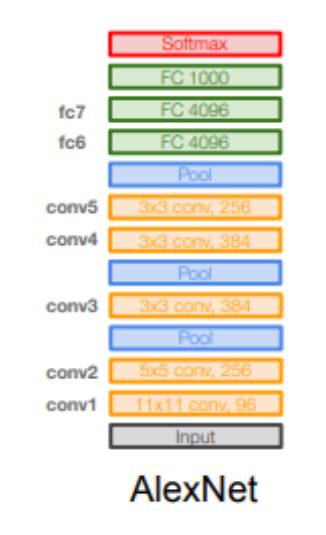

#### 4개 6개 6개 은닉층 반복 
##### (6,6) 컨벌루션 단계에서도 인 채널과 아웃 채널이 똑같이 반복될 수 있음

In [53]:
class Net(nn.modules):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=96, kernel_size=3, padding=1) ## 채널의 수가 노드의 수와 같다 
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(8*8*256, 4096) ## 입력에 대한 
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 11) ## 총 클래스 10개
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x=self.softmax(x)

        return x

In [50]:
transform = transforms.Compose(
    [transforms.ToTensor(),
        transforms.Resize((256, 256)),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                            shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100.0%


Extracting ./data\cifar-10-python.tar.gz to ./data


Device:  cpu


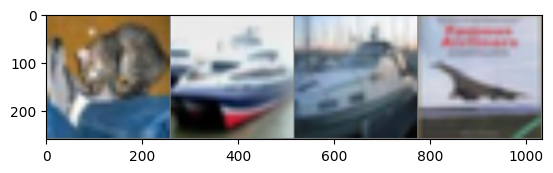

GroundTruth:  cat   ship  ship  plane


RuntimeError: Error(s) in loading state_dict for Net:
	size mismatch for conv1.weight: copying a param with shape torch.Size([6, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([96, 3, 3, 3]).
	size mismatch for conv1.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for conv2.weight: copying a param with shape torch.Size([16, 6, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 96, 3, 3]).
	size mismatch for conv2.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for fc1.weight: copying a param with shape torch.Size([120, 576]) from checkpoint, the shape in current model is torch.Size([4096, 16384]).
	size mismatch for fc1.bias: copying a param with shape torch.Size([120]) from checkpoint, the shape in current model is torch.Size([4096]).
	size mismatch for fc2.weight: copying a param with shape torch.Size([84, 120]) from checkpoint, the shape in current model is torch.Size([4096, 4096]).
	size mismatch for fc2.bias: copying a param with shape torch.Size([84]) from checkpoint, the shape in current model is torch.Size([4096]).
	size mismatch for fc3.weight: copying a param with shape torch.Size([10, 84]) from checkpoint, the shape in current model is torch.Size([11, 4096]).
	size mismatch for fc3.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([11]).

In [54]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Device: ", device)

PATH = './cifar_net.pth'

dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))


net = Net().to(device)
net.load_state_dict(torch.load(PATH), strict=False)


outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                                for j in range(4)))


correct = 0
total = 0

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    recall = 100 * float(correct_count) / total_pred[classname]
    print(f'Recall for class: {classname:5s} is {recall:.1f} %')

del dataiter

In [25]:
import os
os.getcwd()

'c:\\Users\\kimju\\OneDrive\\한국교통대학교\\[2023.06~]workspace\\python_project\\Onebook_python\\AI-실습 코드\\인공지능'